## Lab 07: Computer Vision II: Convolutional Neural Nets for CIFAR-10

### Case of study 06: CIFAR-10 classification

* Implement Convolutional Neural Network using Pytorch library to classify CIFAR-10 dataset   
* CIFAR-10 is a collection of 60,000 colour images with 32 x 32 pixels of dimensionality with 10 classes (6,000 images per each class)  
* The 10 classes of CIFAR-10 are by the picture bellow:  


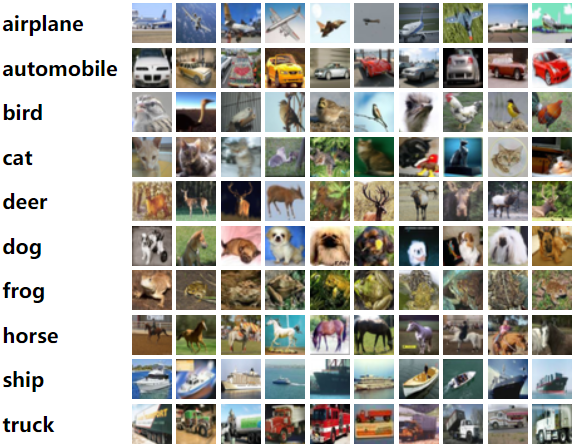

### 1. Prepare Infrastructure

**Compute Engine**: Get available GPU devices

In [81]:
import torch

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())
print("cuda version: ", torch.version.cuda if torch.cuda.is_available() else "none")

pytorch version:  2.5.1+cu121
cuda available:  True
cuda version:  12.1


In [2]:
def get_device():
  # get type of device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"device: {device}")

  # count the number of available GPU
  num_gpus = torch.cuda.device_count()

  if num_gpus:
      print("num gpus: ", num_gpus)

      for i in range(num_gpus):
          gpu_name = torch.cuda.get_device_name(i)
          print(f"GPU {i}: {gpu_name}")
  else:
      print("no GPUs are founded")

  return device

In [3]:
device = get_device()

device: cuda
num gpus:  1
GPU 0: Tesla T4


**Cloud Storage**: connect with Google Drive Hard Disk space

In [4]:
# connect with master root of Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# take position in master
root_path = "/content/drive/MyDrive/Seminar of Specialized topics in AI and ML_5130203/Lesson07_Computer_Vision"
#root_path = "/content/drive/MyDrive/cifar_project"


In [6]:
# list files from main path
!ls "{root_path}"

cifar_data	    cnn_cifar_v3.ipynb	 inference_visualizer.py  models
cnn_cifar_v2.ipynb  fashion_mnist.ipynb  mnist_multiclass.ipynb   __pycache__


In [ ]:
!pip install gdown

In [ ]:
# download dataset
!gdown -O "{root_path}/cifar_data/cifar-10-python.tar.gz" "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

Downloading...
From: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
To: /content/drive/MyDrive/cifar_project/cifar_data/cifar-10-python.tar.gz
100% 170M/170M [00:16<00:00, 10.2MB/s]


In [ ]:
# extract the dataset
!tar -xzvf "{root_path}/cifar_data/cifar-10-python.tar.gz" -C "{root_path}/cifar_data/"

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### 2. Load Dataset

In [7]:
# import packages
import os
import pickle
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [8]:
# class to manage CIFAR-10 dataset
class Cifar10Dataset(Dataset):
  def __init__(self, root_path, is_train = True, transform = None):
    self.root_path = root_path
    self.is_train = is_train
    self.transform = transform
    self.images = []
    self.labels = []

    # load train batches
    if self.is_train:
      for i in range(1, 6):
        train_batch_file = os.path.join(self.root_path, f"data_batch_{i}")
        self.load_batch(train_batch_file)
    else:   # load test batch
      test_batch_file = os.path.join(self.root_path, "test_batch")
      self.load_batch(test_batch_file)

    self.images = np.concatenate(self.images)

  def load_batch(self, batch_file):
    with open(batch_file, "rb") as file:
      batch = pickle.load(file, encoding = 'latin1')
      self.images.append(batch["data"])
      self.labels.extend(batch["labels"])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    # get the batch idx of images
    images = self.images[idx]
    # transpose the data from dimensionality (C, H, W) -> to (H, W, C)
    images = images.reshape(3, 32, 32).transpose(1, 2, 0)
    # get the label idx of images
    labels = self.labels[idx]

    if self.transform:
      images = self.transform(images)

    # dictionary with data
    data = {
        "images": images,
        "labels": labels
    }

    return data
    #return {"images": images, "labels": labels}

In [9]:
size = 32

In [10]:
# create pre-processing transformers
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [11]:
# path of dataset
data_path = f"{root_path}/cifar_data/cifar-10-batches-py"

In [12]:
# load dataset
train_data = Cifar10Dataset(root_path = data_path, is_train = True, transform = train_transforms)
test_data = Cifar10Dataset(root_path = data_path, is_train = False, transform = test_transforms)

In [13]:
print(f"#train-images: {len(train_data.images)}")
print(f"#train-labels: {len(train_data.labels)}")
print(f"#test-images: {len(test_data.images)}")
print(f"#test-labels: {len(test_data.labels)}")

#train-images: 50000
#train-labels: 50000
#test-images: 10000
#test-labels: 10000


In [14]:
# create dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 64, shuffle = False)

In [15]:
# function to iterate through data loader
def iterate_dataloader(data_loader):
  batch = next(iter(data_loader))

  for key, value in batch.items():
    if isinstance(value, torch.Tensor):
      print(f"{key}: {value.shape}")
  print(f"#batches: {len(data_loader)}")


In [16]:
# data loader for train
iterate_dataloader(train_loader)

images: torch.Size([64, 3, 32, 32])
labels: torch.Size([64])
#batches: 782


In [17]:
# data loader for test
iterate_dataloader(test_loader)

images: torch.Size([64, 3, 32, 32])
labels: torch.Size([64])
#batches: 157


### 3. Build Architecture

Building blocks of the Convolutional Neural Network  

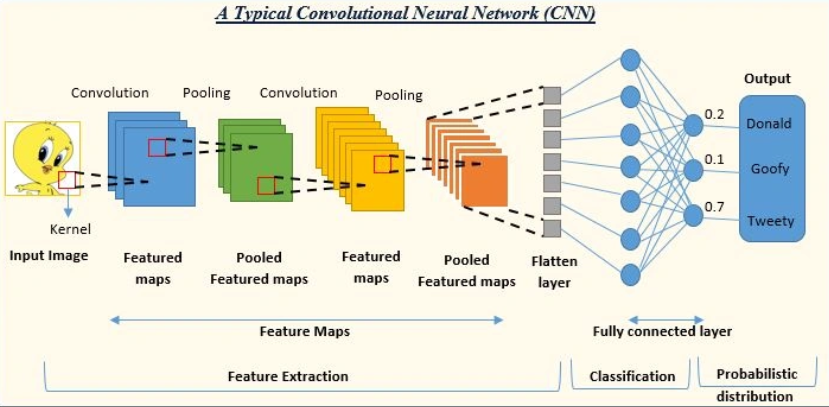

Convolutional Operation  

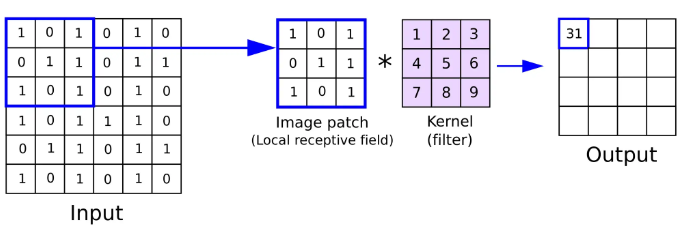

Max Pooling operation  
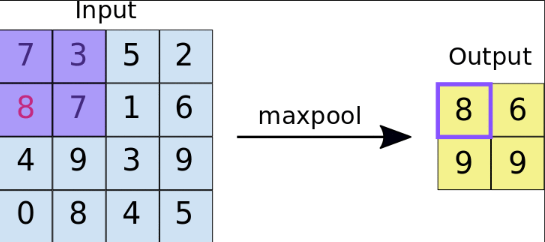

In [18]:
# import packages
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torchsummary import summary

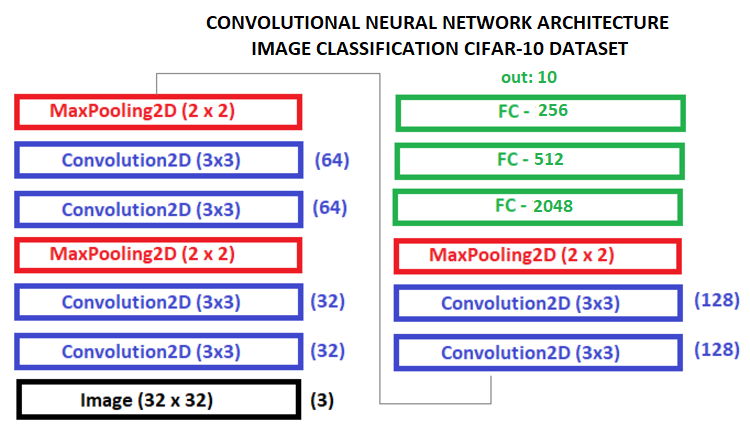

In [19]:
class ConvolutionalNet(nn.Module):

  def __init__(self, num_classes=10):
    super(ConvolutionalNet, self).__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, stride=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
    self.bn6 = nn.BatchNorm2d(128)
    # max pooling layers
    self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))

    # fully-connected layers
    self.fc1 = nn.Linear(in_features = 2048, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = num_classes)
    self.bn_fc1 = nn.BatchNorm1d(512)
    self.bn_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    # convolutional
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.maxpool(out)
    out = F.relu(self.bn3(self.conv3(out)))
    out = F.relu(self.bn4(self.conv4(out)))
    out = self.maxpool(out)
    out = F.relu(self.bn5(self.conv5(out)))
    out = F.relu(self.bn6(self.conv6(out)))
    out = self.maxpool(out)

    # flattened
    out = out.view(out.size(0), -1)   # batch-size dim maintain

    # fully-connected layers
    out = F.relu(self.bn_fc1(self.fc1(out)))
    out = F.relu(self.bn_fc2(self.fc2(out)))
    out = self.fc3(out)

    return out

  def get_total_params(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [ ]:
# define the model
model = ConvolutionalNet()
model = model.to(device)
model

ConvolutionalNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
print(f"total #params = {round(model.get_total_params()/10**6, 2)} M")

total #params = 1.41 M


In [ ]:
# define optimizer
optimizer = AdamW(model.parameters(), lr = 5e-4)

# define loss function
criterion = nn.CrossEntropyLoss()

### 4. Train/Validation

In [26]:
# import packages
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

In [ ]:
# define the training function
def train_model(model, train_loader, device, optimizer, criterion):
  model.train()
  train_loss = 0.0
  num_correct = 0

  for batch in train_loader:
    x_batch = batch["images"]
    y_batch = batch["labels"]
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    optimizer.zero_grad()
    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    predictions = logits.argmax(-1)
    num_correct += (predictions == y_batch).sum().item()

  accuracy = num_correct / len(train_loader.dataset)

  return train_loss/len(train_loader), accuracy


In [ ]:
# define the test function
def test_model(model, test_loader, device):
  model.eval()
  test_loss = 0.0
  num_correct = 0

  with torch.no_grad():
    for batch in test_loader:
      x_batch = batch["images"]
      y_batch = batch["labels"]
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      logits = model(x_batch)
      loss = criterion(logits, y_batch)
      test_loss += loss.item()

      predictions = logits.argmax(-1)
      num_correct += (predictions == y_batch).sum().item()
  accuracy = num_correct / len(test_loader.dataset)

  return test_loss / len(test_loader), accuracy


In [ ]:
results = []

In [ ]:
# Define the function to run the training and evaluation process
def run_training(model, train_loader, test_loader, optimizer, criterion, device, num_epochs):

  best_test_acc = 0.0
  train_losses = []
  test_losses = []
  train_accs = []
  test_accs = []

  # define path to save model
  model_save_path = f"{root_path}/models/"

  # make the iterative train/test process
  start_time = time.time()

  for epoch in range(num_epochs):
    print("Training process...")
    train_loss, train_accuracy = train_model(model, train_loader, device, optimizer, criterion)
    test_loss, test_accuracy = test_model(model, test_loader, device)
    print(f"Epoch {epoch}/{num_epochs} =====> Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # append results
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

    # select and save the best model
    if test_accuracy > best_test_acc:
      best_test_acc = test_accuracy
      model_filename = f"{model_save_path}cnn_v0{epoch + 1}.pt"
      #model_filename = model_save_path + str(epoch+1) + ".pt"
      torch.save(model.state_dict(), model_filename)
      print(f"*** Model saved at epoch {epoch+1}/{num_epochs} with test accuracy = {best_test_acc:.4f} ***")

  results.append({
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accs,
    "test_accuracies": test_accs
  })

  end_time = time.time()
  training_time = end_time - start_time
  print(f"Training time: {training_time:.2f} seconds")
  print("Training finished!")


In [ ]:
run_training(model, train_loader, test_loader, optimizer, criterion, device, num_epochs = 50)

Training process...
Epoch 0/50 =====> Train Loss: 1.5996, Train Accuracy: 0.4193, Test Loss: 1.2011, Test Accuracy: 0.5866
*** Model saved at epoch 1/50 with test accuracy = 0.5866 ***
Training process...
Epoch 1/50 =====> Train Loss: 1.2800, Train Accuracy: 0.5438, Test Loss: 1.0614, Test Accuracy: 0.6301
*** Model saved at epoch 2/50 with test accuracy = 0.6301 ***
Training process...
Epoch 2/50 =====> Train Loss: 1.1483, Train Accuracy: 0.5913, Test Loss: 0.8478, Test Accuracy: 0.7028
*** Model saved at epoch 3/50 with test accuracy = 0.7028 ***
Training process...
Epoch 3/50 =====> Train Loss: 1.0687, Train Accuracy: 0.6229, Test Loss: 0.7624, Test Accuracy: 0.7303
*** Model saved at epoch 4/50 with test accuracy = 0.7303 ***
Training process...
Epoch 4/50 =====> Train Loss: 1.0069, Train Accuracy: 0.6453, Test Loss: 0.7712, Test Accuracy: 0.7323
*** Model saved at epoch 5/50 with test accuracy = 0.7323 ***
Training process...
Epoch 5/50 =====> Train Loss: 0.9729, Train Accuracy: 0

### 5. Monitoring the results

In [20]:
import matplotlib.pyplot as plt

In [ ]:
# function to monitorize results
def monitoring_results(results, metrics, labels, title, y_label):
  results = results[0]
  plt.plot(results[metrics[0]], label = labels[0])
  plt.plot(results[metrics[1]], label = labels[1])
  plt.legend(frameon = False)
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel(y_label)
  plt.tight_layout()
  plt.show()

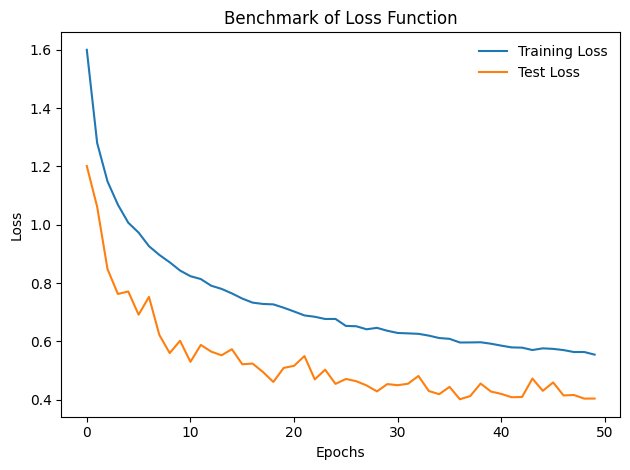

In [ ]:
monitoring_results(results,
                   metrics = ["train_losses", "test_losses"],
                   labels = ["Training Loss", "Test Loss"],
                   title = "Benchmark of Loss Function",
                   y_label = "Loss")

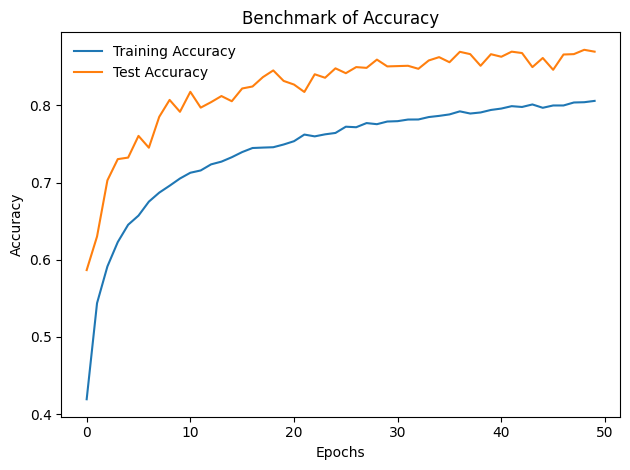

In [ ]:
monitoring_results(results,
                   metrics = ["train_accuracies", "test_accuracies"],
                   labels = ["Training Accuracy", "Test Accuracy"],
                   title = "Benchmark of Accuracy",
                   y_label = "Accuracy")

### 6. Testing

In [21]:
import pandas as pd

In [42]:
def get_best_model(model_path):
  best_model = ConvolutionalNet()
  best_model.load_state_dict(torch.load(model_path,
                                        map_location = torch.device(device),
                                        weights_only = True))
  best_model = best_model.to(device)

  return best_model

In [43]:
# path of the best model
best_model_path = f"{root_path}/models/cnn_v049.pt"

In [47]:
def testing(model_path, test_loader, device):
    # Retrieve the best model
    model = get_best_model(model_path)
    model.eval()

    test_results = []
    lst_ytest = []
    lst_ypred = []

    with torch.no_grad():
      for batch in test_loader:  # Iterate through all batches in test_loader
        x_test = batch["images"].to(device)
        y_test = batch["labels"].to(device)

        logits = model(x_test)
        y_probs = F.softmax(logits, dim=1).cpu().numpy()  # Move to CPU before converting to numpy
        y_pred = np.argmax(y_probs, axis=1)

        lst_ytest.extend(y_test.cpu().numpy())
        lst_ypred.extend(y_pred)

    # Calculate metrics for model quality
    accuracy = accuracy_score(lst_ytest, lst_ypred)
    precision = precision_score(lst_ytest, lst_ypred, average='weighted')
    recall = recall_score(lst_ytest, lst_ypred, average='weighted')
    f1 = f1_score(lst_ytest, lst_ypred, average='weighted')

    # Store results
    test_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # Convert results to DataFrame
    frame_results = pd.DataFrame(test_results)

    return frame_results

In [48]:
testing_results = testing(best_model_path, test_loader, device)

In [49]:
print(testing_results)

   accuracy  precision  recall  f1_score
0    0.8719   0.874216  0.8719  0.871929


### 7. Inference

In [75]:
import os
os.chdir(root_path)

In [70]:
# take tensor structure for 1 specific image
print("Image-dim: ")
print(next(iter(test_loader))["images"][12].shape)
print("Tensor of images: ")
print(next(iter(test_loader))["images"][12])

Image-dim: 
torch.Size([3, 32, 32])
Tensor of images: 
tensor([[[-0.2863, -0.3569, -0.3176,  ..., -0.8275, -0.8275, -0.8588],
         [-0.2627, -0.3804, -0.2941,  ..., -0.7176, -0.5216, -0.6314],
         [-0.2627, -0.3255, -0.0588,  ..., -0.5765, -0.3569, -0.5373],
         ...,
         [-0.1686, -0.1922, -0.1922,  ..., -0.8431, -0.8902, -0.8353],
         [-0.1059, -0.1059, -0.0588,  ..., -0.7176, -0.7098, -0.8275],
         [ 0.0667,  0.0275,  0.0431,  ..., -0.3725, -0.3882, -0.7804]],

        [[-0.4980, -0.5451, -0.4275,  ..., -0.8980, -0.8824, -0.8980],
         [-0.4902, -0.5608, -0.3882,  ..., -0.8510, -0.6392, -0.7176],
         [-0.4824, -0.4902, -0.1765,  ..., -0.7412, -0.4980, -0.6392],
         ...,
         [-0.2392, -0.2471, -0.2235,  ..., -0.7333, -0.7098, -0.7490],
         [-0.1922, -0.1843, -0.1373,  ..., -0.6314, -0.6078, -0.7647],
         [-0.0510, -0.0980, -0.1059,  ..., -0.3412, -0.4353, -0.7569]],

        [[-0.7647, -0.7647, -0.5373,  ..., -0.8980, -0.8980, 

In [71]:
def inference(model_path, data_loader, device, sample_pos):
  # Retrieve the best model
  model = get_best_model(model_path)
  model.to(device)
  model.eval()

  batch = next(iter(data_loader))
  x_test = batch["images"][sample_pos].unsqueeze(0).to(device)
  y_test = batch["labels"][sample_pos].to(device)

  with torch.no_grad():
    output = model(x_test)
    probs = F.softmax(output, dim = 1)

  return x_test, y_test, probs


In [72]:
image, label, prob_dist = inference(model_path = best_model_path,
                                    data_loader = test_loader,
                                    device = device,
                                    sample_pos = 12)
print(f"True label: {label}")
print(f"Prob distribution: {prob_dist}")

True label: 5
Prob distribution: tensor([[9.1951e-05, 1.0637e-05, 5.4600e-04, 2.9613e-02, 1.9740e-02, 7.0718e-01,
         3.3157e-02, 2.0949e-01, 6.4190e-05, 1.0095e-04]], device='cuda:0')
